In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import Weibo2014
from moabb.datasets import Zhou2016
from moabb.datasets import BNCI2014004
from moabb.datasets import BNCI2014002
from moabb.datasets import BNCI2015001
from moabb.datasets import AlexMI


from moabb.evaluations import WithinSessionEvaluation
from moabb.evaluations import CrossSessionEvaluation


import mne
from mne.preprocessing import Xdawn
from mne.decoding import CSP


from moabb.paradigms import MotorImagery
from pyriemann.estimation import Covariances
from pyriemann.utils.covariance import covariances
from pyriemann.estimation import ERPCovariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from pyriemann.tangentspace import TangentSpace
from pyriemann.datasets import make_gaussian_blobs
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [2]:
paradigm = MotorImagery()
paradigm_name = 'MI'

Choosing from all possible events


In [3]:
pipelines = {}
pipelines["(1) epo-mdm-euc"] = make_pipeline(MDM(metric="euclid"))
#pipelines["(2) epo-knn-euc"] = make_pipeline(KNearestNeighbor(), MDM(metric="euclid"))
# #default 5 neighbors
# pipelines["(3) cov-dia-lda"] = make_pipeline(Covariances('oas'), LDA())
# #sch for schaffer
pipelines["(4) epo-csp-lda"] = make_pipeline(CSP(), LDA())
pipelines["(5) cov-knn-euc"] = make_pipeline(Covariances('oas'), KNearestNeighbor(metric="euclid"))
pipelines["(6) cov-knn-rie"] = make_pipeline(Covariances('oas'), KNearestNeighbor())
# # #default riemannian
pipelines["(7) cov-mdm-euc"] = make_pipeline(Covariances('oas'), MDM(metric="euclid"))
pipelines["(8) cov-mdm-rie"] = make_pipeline(Covariances('oas'), MDM())
pipelines["(9) cov-tgs-lda"] = make_pipeline(Covariances('oas'), TangentSpace(), LDA())
# # #(default: 'riemann')
#4, 8, 9


In [4]:
n_matrices = 100  # how many matrices to sample on each class
n_dim = 4  # dimensionality of the data points
sigma = 0.5  # dispersion of the Gaussian distributions
random_state = 42  # ensure reproducibility

In [5]:
scores_array = []
deltas_array = np.linspace(0, 5*sigma, 5)
DSM = []
DSL = []
data_source = {}
for delta in deltas_array:
    data_source['covs'], data_source['labels'] = make_gaussian_blobs(n_matrices=n_matrices, n_dim=n_dim, class_sep=delta, class_disp=sigma, random_state=random_state)
    DSM.append(data_source['covs'])
    DSL.append(data_source['labels'])
    scores_array.append(cross_val_score(pipelines["(9) cov-tgs-lda"], data_source['covs'], data_source['labels'], cv=5, scoring='roc_auc').mean())
print(scores_array)

[0.31725000000000003, 0.75, 0.9345000000000001, 0.9889999999999999, 0.999]


In [6]:
new_labels_names = []
labels = DSL[0]
while len(new_labels_names)<2:
    for elt in labels:
        if elt not in new_labels_names:
            new_labels_names.append(elt)
print(new_labels_names)
new_labels = [0,1]
print(new_labels)
source = {}
target_train = {}
target_test = {}

[0.0, 1.0]
[0, 1]


In [7]:
from sklearn.model_selection import KFold

def pred_truth(data_source_covs, data_source_labels, n_folds=5):
    n_folds = 5
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    PREDICTION = []
    TRUTH = []
    for train, test in cv.split(data_source_covs):
        TRUTH.append(data_source_labels[test])
        model = pipelines["(9) cov-tgs-lda"].fit(data_source_covs[train], data_source_labels[train])
        a = model.predict_proba(data_source_covs[test])
        PREDICTION.append(a)
    return PREDICTION, TRUTH

In [10]:
def roc_homemade(prediction, truth, threshold):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    prediction2 =  []
    truth2 = []
    a = 0
    for i in range(len(prediction)):
        if prediction[i][0]>threshold:
            prediction2.append(0)
        else:
            prediction2.append(1)
        if truth[i] == 0: #right_hand
            truth2.append(0)
        elif truth[i] == 1: #feet
            truth2.append(1)
        if prediction2[a] == new_labels[0] and truth2[a] == new_labels[0]:
            tp += 1
        elif prediction2[a] == new_labels[1] and truth2[a] == new_labels[1]:
            tn += 1
        elif prediction2[a] == new_labels[0] and truth2[a] == new_labels[1]:
            fp += 1
        elif prediction2[a] == new_labels[1] and truth2[a] == new_labels[0]:
            fn += 1
        a += 1
    return tp, tn, fp, fn

def sensitivity(tp, tn, fp, fn):
    if tp+fn == 0:
        return 0
    return tp/(tp+fn)

def one_specificity(tp, tn, fp, fn):
    if fp+tn == 0:
        return 0
    return 1- (tn/(tn+fp))

def accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+tn+fp+fn)


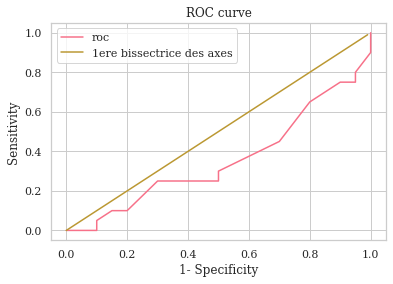

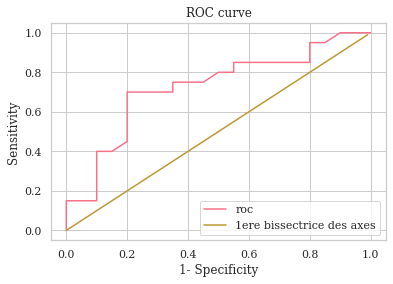

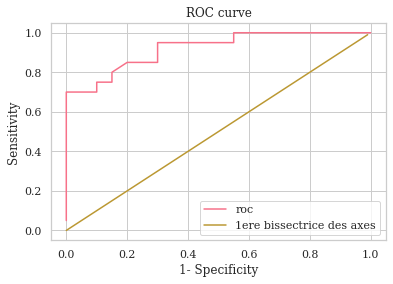

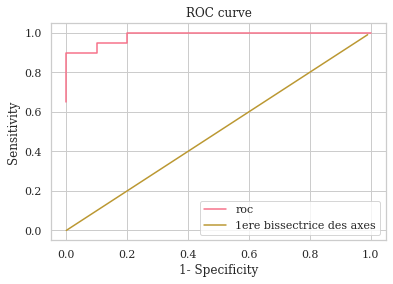

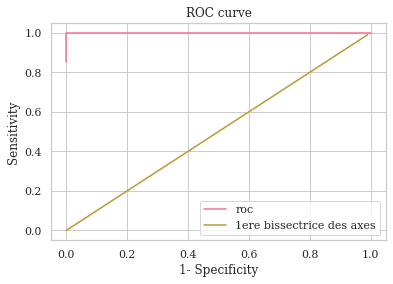

In [11]:

def print_fct_roc(i_data, k_fold):
    l_one_spec = []
    l_senstivity = []
    n= 100
    THRESHOLD = [i/n for i in range(0,n)]
    PREDICTION, TRUTH = pred_truth(DSM[i_data], DSL[i_data])
    for i in range(n):
        tp, tn, fp, fn = roc_homemade(PREDICTION[k_fold], TRUTH[k_fold], THRESHOLD[i])
        l_one_spec.append(one_specificity(tp, tn, fp, fn))
        l_senstivity.append(sensitivity(tp, tn, fp, fn))
    plt.plot(l_one_spec, l_senstivity, label="roc")
    plt.plot(THRESHOLD, THRESHOLD, label="1ere bissectrice des axes")
    plt.xlabel('1- Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.legend()
    plt.show()
    
for i in range(len(DSM)):
    print_fct_roc(i, 3)


In [12]:
def fct_roc(i_data, k_fold):
    l_one_spec = []
    l_senstivity = []
    n= 100
    THRESHOLD = [i/n for i in range(0,n)]
    PREDICTION, TRUTH = pred_truth(DSM[i_data], DSL[i_data])
    for i in range(n):
        tp, tn, fp, fn = roc_homemade(PREDICTION[k_fold], TRUTH[k_fold], THRESHOLD[i])
        l_one_spec.append(one_specificity(tp, tn, fp, fn))
        l_senstivity.append(sensitivity(tp, tn, fp, fn))
    return l_one_spec, l_senstivity

In [13]:
def mean(L):
    return sum(L)/len(L)

def auc_roc(l_one_spec, l_senstivity):
    auc = 0
    for i in range(len(l_one_spec)-1):
        auc += (l_one_spec[i+1]-l_one_spec[i])*(l_senstivity[i+1]+l_senstivity[i])/2
    return abs(auc)
AUC = []
for i_data in range(len(DSM)):
    AUC.append(mean([auc_roc(fct_roc(i_data, k_fold)[0], fct_roc(i_data, k_fold)[1]) for k_fold in range(5)]))

In [16]:
def accuracy_homemade(prediction, truth):
    prediction2 =  []
    truth2 = []
    a = 0
    cpt = 0
    threshold = 0.5
    for i in range(len(prediction)):
        for j in range(len(prediction[i])):
            if prediction[i][j][0]>threshold:
                prediction2.append(0)
            else:
                prediction2.append(1)
            if truth[i][j] == 0: #right_hand
                truth2.append(0)
            elif truth[i][j] == 1:  #feet
                truth2.append(1) 
            if prediction2[a] == truth2[a]:
                cpt += 1
            a += 1
    return cpt/a


ACCURACY = []
for i in range(len(DSM)):
    pred = pred_truth(DSM[i], DSL[i], n_folds=5)[0]
    truth = pred_truth(DSM[i], DSL[i], n_folds=5)[1]
    ACCURACY.append(accuracy_homemade(pred, truth))

In [15]:
print(ACCURACY)
print(AUC)

[0.36, 0.72, 0.85, 0.95, 0.985]
[0.3171025575301891, 0.7881708746297562, 0.934769646654515, 0.9894546214019897, 1.0]


In [18]:
import csv

with open('results_gauss.csv', 'w', newline='') as csvfile:
    fieldnames = ['count', 'auc_roc_score', 'accuracy', 'subject','dataset', 'pipeline']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(ACCURACY)):
        writer.writerow({'count': i, 'auc_roc_score': AUC[i], 'accuracy': ACCURACY[i], 'subject': None, 'dataset': f'make_gaussian_blobs(n_matrices=100, n_dim=4, class_sep={i}, class_disp=0.5, random_state=42)', 'pipeline': '(9) cov-tgs-lda'})
   